In [ ]:
# IoT Intrusion Detection System - Machine Learning Project

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)



In [ ]:

# TASK 1: DESCRIPTIVE ANALYSIS OF DATA
print("TASK 1: DESCRIPTIVE ANALYSIS")

# Load the dataset
print("\n1.1 Loading Dataset")
try:
    df = pd.read_csv('IoT_Intrusion.csv')
    print(f"Dataset loaded")
    print(f"  Shape: {df.shape[0]} rows × {df.shape[1]} columns")
except FileNotFoundError:
    print("Dataset file not found.")
    # Creating sample structure for demonstration
    df = pd.DataFrame()


TASK 1: DESCRIPTIVE ANALYSIS

1.1 Loading Dataset
Dataset loaded
  Shape: 1048575 rows × 47 columns


In [ ]:
# 1.2 Basic Information
print("\n1.2 Dataset Overview:")
print(df.head(10))
print("\n1.3 Data Types and Missing Values:")
print(df.info())

# 1.4 Statistical Summary
print("\n1.4 Statistical Summary:")
print(df.describe())

# 1.5 Missing Values Analysis
print("\n1.5 Missing Values Analysis:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
if len(missing_df) > 0:
    print(missing_df)
else:
    print("No missing values detected")


1.2 Dataset Overview:
   flow_duration  Header_Length  Protocol Type  Duration         Rate  \
0       0.000000          54.00           6.00     64.00     0.329807   
1       0.000000          57.04           6.33     64.00     4.290556   
2       0.000000           0.00           1.00     64.00    33.396799   
3       0.328175       76175.00          17.00     64.00  4642.133010   
4       0.117320         101.73           6.11     65.91     6.202211   
5       0.000000           0.00          47.00     64.00     1.954123   
6       1.052463         108.00           6.00     64.00     1.902353   
7       0.142555        2322.79           6.66     79.77   493.283636   
8       0.002135         192.52          16.89     65.73    16.883240   
9       0.000000          54.20           6.00     64.00    11.243547   

         Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  ...  \
0     0.329807    0.0                1                0                1  ...   
1     4.290


1.6 Target Variable Distribution:
Target Column: label

Class Distribution:
label
DDoS-ICMP_Flood            161281
DDoS-UDP_Flood             121205
DDoS-TCP_Flood             101293
DDoS-PSHACK_Flood           92395
DDoS-SYN_Flood              91644
DDoS-RSTFINFlood            90823
DDoS-SynonymousIP_Flood     80680
DoS-UDP_Flood               74787
DoS-TCP_Flood               59807
DoS-SYN_Flood               45207
BenignTraffic               24476
Mirai-greeth_flood          22115
Mirai-udpplain              20166
Mirai-greip_flood           16952
DDoS-ICMP_Fragmentation     10223
MITM-ArpSpoofing             7019
DDoS-ACK_Fragmentation       6431
DDoS-UDP_Fragmentation       6431
DNS_Spoofing                 4034
Recon-HostDiscovery          3007
Recon-OSScan                 2225
Recon-PortScan               1863
DoS-HTTP_Flood               1680
VulnerabilityScan             809
DDoS-HTTP_Flood               626
DDoS-SlowLoris                493
DictionaryBruteForce          324

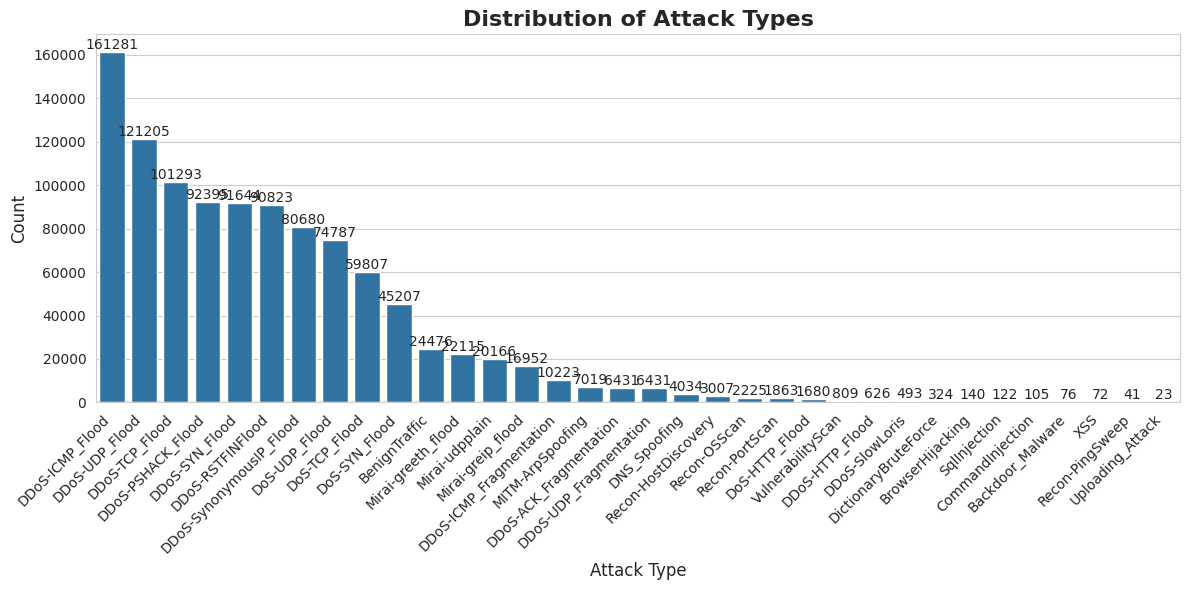


1.7 Feature Correlation Analysis:


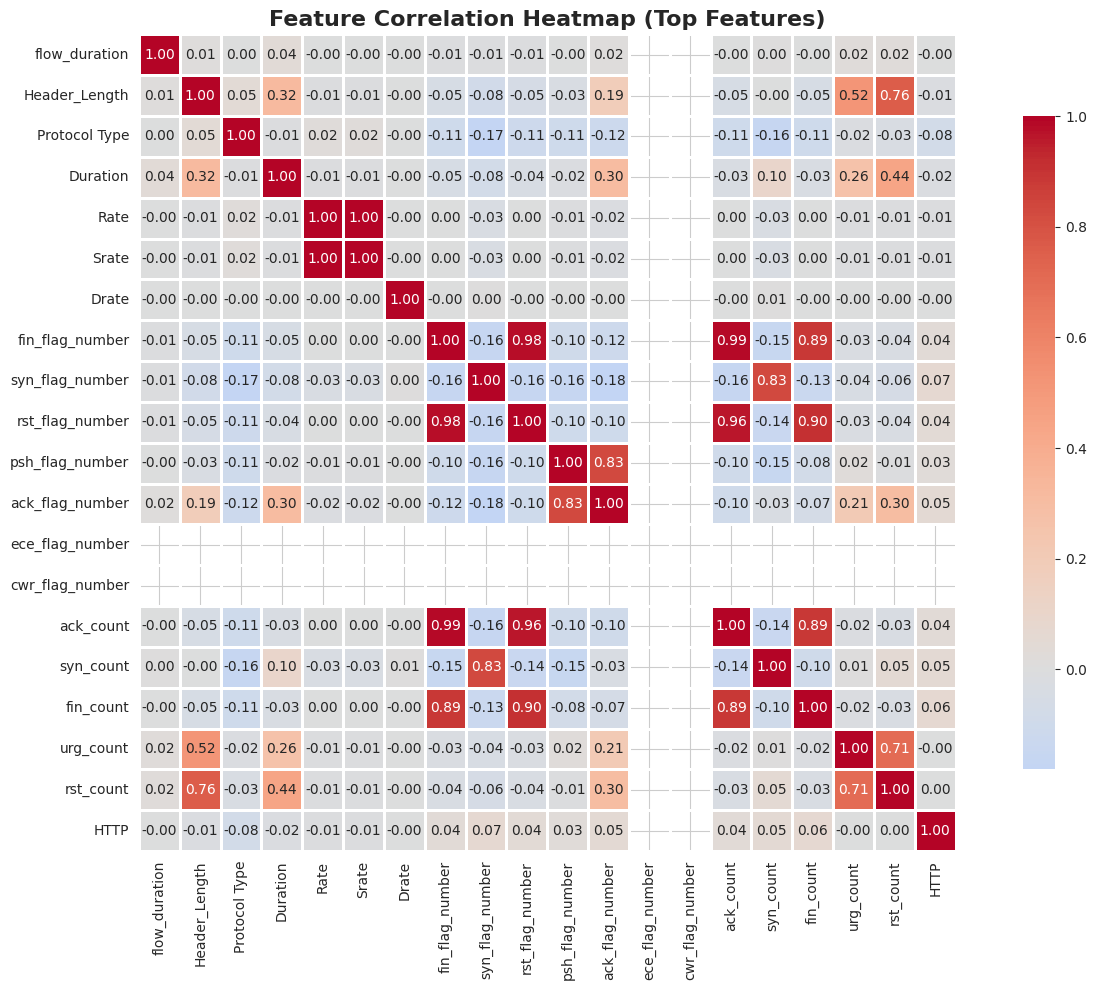

In [ ]:
# 1.6 Target Variable Distribution
print("\n1.6 Target Variable Distribution:")
target_cols = ['Cat', 'label', 'attack_type', 'Label', 'type']
target_col = None
for col in target_cols:
    if col in df.columns:
        target_col = col
        break

if target_col:
    print(f"Target Column: {target_col}")
    print("\nClass Distribution:")
    class_dist = df[target_col].value_counts()
    print(class_dist)
    print("\nClass Percentages:")
    print(df[target_col].value_counts(normalize=True) * 100)

    # Visualize class distribution
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=df, x=target_col, order=df[target_col].value_counts().index)
    plt.title('Distribution of Attack Types', fontsize=16, fontweight='bold')
    plt.xlabel('Attack Type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("Target column not found. Please specify the correct target column name.")

# 1.7 Feature Correlation Analysis
print("\n1.7 Feature Correlation Analysis:")
# Select only numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    correlation_matrix = df[numeric_cols].corr()

    # Plot correlation heatmap for top features
    plt.figure(figsize=(14, 10))
    top_features = min(20, len(numeric_cols))  # Limit to top 20 features
    top_corr = correlation_matrix.iloc[:top_features, :top_features]
    sns.heatmap(top_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Heatmap (Top Features)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [ ]:
# Importation nécessaire pour SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

# TASK 2: DATA PRE-PROCESSING
print("TASK 2: DATA PRE-PROCESSING (WITH SMOTE & CLASS GROUPING)")

# 2.1 Handle Missing Values
print("\n2.1 Handling Missing Values:")
if df.isnull().sum().sum() > 0:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    print("  Missing values handled")
else:
    print("  No missing values to handle")

# 2.2 Remove Duplicates
print("\n2.2 Removing Duplicates:")
initial_rows = len(df)
df.drop_duplicates(inplace=True)
print(f"  Removed {initial_rows - len(df)} duplicate rows")


#  GESTION DES CLASSES RARES

print("\n2.2b Grouping Rare Classes (< 100 samples):")
if target_col:
    # Compter les occurrences
    class_counts = df[target_col].value_counts()
    # Identifier les classes rares (seuil à 100 pour que SMOTE fonctionne bien)
    rare_classes = class_counts[class_counts < 100].index

    print(f"  Found {len(rare_classes)} rare classes to group: {list(rare_classes)}")

    # Remplacer les labels rares par 'Rare_Attack'
    df[target_col] = df[target_col].replace(rare_classes, 'Rare_Attack')

    print("  New Class Distribution:")
    print(df[target_col].value_counts())

# 2.3 Encode Categorical Variables
print("\n2.3 Encoding Categorical Variables:")
label_encoders = {}
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if col != target_col:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

TASK 2: DATA PRE-PROCESSING (WITH SMOTE & CLASS GROUPING)

2.1 Handling Missing Values:
  No missing values to handle

2.2 Removing Duplicates:
  Removed 65556 duplicate rows

2.2b Grouping Rare Classes (< 100 samples):
  Found 4 rare classes to group: ['Backdoor_Malware', 'XSS', 'Recon-PingSweep', 'Uploading_Attack']
  New Class Distribution:
label
DDoS-ICMP_Flood            137288
DDoS-UDP_Flood             121205
DDoS-TCP_Flood              92028
DDoS-SYN_Flood              86191
DDoS-PSHACK_Flood           83914
DDoS-SynonymousIP_Flood     78994
DDoS-RSTFINFlood            78439
DoS-UDP_Flood               74138
DoS-TCP_Flood               57493
DoS-SYN_Flood               44389
BenignTraffic               24476
Mirai-greeth_flood          21817
Mirai-udpplain              20166
Mirai-greip_flood           16746
DDoS-ICMP_Fragmentation     10216
MITM-ArpSpoofing             7019
DDoS-UDP_Fragmentation       6431
DDoS-ACK_Fragmentation       6429
DNS_Spoofing                 4034
Re

In [ ]:
import time
# 2.4 Feature Selection & Separation
print("\n2.4 Feature Engineering & Selection:")

if target_col:
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode target variable
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)
    print(f"  Target variable encoded. Classes: {len(le_target.classes_)}")

    # Remove constant features
    constant_features = [col for col in X.columns if X[col].nunique() <= 1]
    if constant_features:
        X = X.drop(columns=constant_features)
        print(f"  Removed {len(constant_features)} constant features")

    # Remove highly correlated features
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
    if to_drop:
        X = X.drop(columns=to_drop)
        print(f"  Removed {len(to_drop)} highly correlated features")

# 2.5 Feature Scaling
print("\n2.5 Feature Scaling:")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"  Scaled data shape: {X_scaled.shape}")

# 2.6 TRAIN-TEST SPLIT (BEFORE SMOTE)
print("\n2.6 Train-Test Split:")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"  Original Training set shape: {X_train.shape}")
print(f"  Testing set shape: {X_test.shape}")

# 2.7 SMOTE (TRAIN SET)
print("\n2.7 Applying SMOTE to Training Set:")
print("  Oversampling minority classes to balance the dataset...")

# Initialisation SMOTE
# k_neighbors=5
smote = SMOTE(random_state=42, k_neighbors=5)

start_smote = time.time()
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
end_smote = time.time()

print(f"  SMOTE completed in {end_smote - start_smote:.2f} seconds.")
print(f"  Resampled Training set shape: {X_train_res.shape}")

# Distribution verification after SMOTE
print("  New Class Distribution in Training Set:")
counter = Counter(y_train_res)
for k, v in list(counter.items())[:5]:
    print(f"    Class {k}: {v} samples")

X_train = X_train_res
y_train = y_train_res


2.4 Feature Engineering & Selection:
  Target variable encoded. Classes: 31
  Removed 5 constant features
  Removed 9 highly correlated features

2.5 Feature Scaling:
  Scaled data shape: (983019, 32)

2.6 Train-Test Split:
  Original Training set shape: (786415, 32)
  Testing set shape: (196604, 32)

2.7 Applying SMOTE to Training Set:
  Oversampling minority classes to balance the dataset...
  SMOTE completed in 268.96 seconds.
  Resampled Training set shape: (3404730, 32)
  New Class Distribution in Training Set:
    Class 5: 109830 samples
    Class 11: 109830 samples
    Class 6: 109830 samples
    Class 8: 109830 samples
    Class 7: 109830 samples


PROBLEM STATEMENT:
------------------
Design and develop a supervised Machine Learning classification system for
real-time intrusion detection in IoT networks.

OBJECTIVE:
----------
Build a multi-class classifier that can accurately distinguish between:
  • Benign (normal) network traffic
  • DDoS attacks
  • Mirai botnet attacks
  • Brute Force attacks
  • Other sophisticated network intrusions

INPUT:
------
Network flow features extracted from IoT device traffic, including:
  • Packet-level characteristics (size, count, timing)
  • Flow-level statistics (duration, bytes, flags)
  • Protocol information
  • Connection patterns

OUTPUT:
-------
Classification label indicating the type of traffic:
  • Binary: Benign vs. Attack
  • Multi-class: Specific attack type identification

EVALUATION METRICS:
-------------------
Primary Metrics:
  • Accuracy: Overall correctness of predictions
  • Precision: Minimize false positives (false alarms)
  • Recall: Minimize false negatives (missed attacks)
  • F1-Score: Harmonic mean of precision and recall

Secondary Metrics:
  • Confusion Matrix: Detailed per-class performance
  • ROC-AUC: Model's discriminative ability
  • Training/Inference Time: Real-time deployment feasibility

CONSTRAINTS:
------------
  • Must handle imbalanced classes (some attacks are rare)
  • Must be computationally efficient for IoT environments
  • Must minimize false positives to avoid alert fatigue
  • Must achieve high recall for critical attacks (zero-day tolerance)

APPROACH:
---------
  1. Supervised learning with labeled network flow data
  2. Feature engineering to capture attack signatures
  3. Ensemble methods for robust classification
  4. Cross-validation for generalization assessment
  5. Hyperparameter tuning for optimal performance

In [ ]:
print("\nDATA CHARACTERISTICS:")
print(f"  • Total Samples: {len(df):,}")
print(f"  • Number of Features: {X.shape[1]}")
print(f"  • Number of Classes: {len(np.unique(y_encoded))}")
print(f"  • Class Distribution:")
for class_name, count in zip(le_target.classes_,
                              np.bincount(y_encoded)):
    percentage = (count / len(y_encoded)) * 100
    print(f"    - {class_name}: {count:,} samples ({percentage:.2f}%)")


print("\nTRAINING SET CHARACTERISTICS (After SMOTE):")
print("-" * 40)
print(f"  • Total Training Samples: {len(y_train):,}")

# Show distribution on train set
from collections import Counter
counter = Counter(y_train)
for label_idx, count in sorted(counter.items()):
    class_name = le_target.inverse_transform([label_idx])[0]
    percentage = (count / len(y_train)) * 100
    print(f"    - {class_name}: {count:,} samples ({percentage:.2f}%)")


DATA CHARACTERISTICS:
  • Total Samples: 983,019
  • Number of Features: 32
  • Number of Classes: 31
  • Class Distribution:
    - BenignTraffic: 24,476 samples (2.49%)
    - BrowserHijacking: 140 samples (0.01%)
    - CommandInjection: 105 samples (0.01%)
    - DDoS-ACK_Fragmentation: 6,429 samples (0.65%)
    - DDoS-HTTP_Flood: 626 samples (0.06%)
    - DDoS-ICMP_Flood: 137,288 samples (13.97%)
    - DDoS-ICMP_Fragmentation: 10,216 samples (1.04%)
    - DDoS-PSHACK_Flood: 83,914 samples (8.54%)
    - DDoS-RSTFINFlood: 78,439 samples (7.98%)
    - DDoS-SYN_Flood: 86,191 samples (8.77%)
    - DDoS-SlowLoris: 493 samples (0.05%)
    - DDoS-SynonymousIP_Flood: 78,994 samples (8.04%)
    - DDoS-TCP_Flood: 92,028 samples (9.36%)
    - DDoS-UDP_Flood: 121,205 samples (12.33%)
    - DDoS-UDP_Fragmentation: 6,431 samples (0.65%)
    - DNS_Spoofing: 4,034 samples (0.41%)
    - DictionaryBruteForce: 324 samples (0.03%)
    - DoS-HTTP_Flood: 1,680 samples (0.17%)
    - DoS-SYN_Flood: 44,389 sa

BASELINE MODEL SELECTION:
-------------------------
Model: Random Forest Classifier

RATIONALE:
  • Handles high-dimensional feature spaces effectively
  • Robust to outliers and noisy data (common in network traffic)
  • Provides feature importance rankings for interpretability
  • Ensemble method reduces overfitting risk
  • Works well with imbalanced datasets
  • No assumption about data distribution
  • Fast training and prediction (suitable for IoT)
  • Baseline for comparison with advanced models (XGBoost, Neural Networks)

In [ ]:
print("\n4.1 Model Training:")

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Handle class imbalance
)

print("  Training Random Forest Classifier")
print(f"  Hyperparameters:")
print(f"    - n_estimators: 100")
print(f"    - max_depth: 20")
print(f"    - min_samples_split: 10")
print(f"    - min_samples_leaf: 4")
print(f"    - class_weight: balanced")

print("\n  4.1b Optimizing Training Speed (Subsampling):")
import pandas as pd
import time

sample_size = 20000

if len(y_train) > sample_size:
    print(f"  Dataset is large ({len(y_train):,} samples). Subsampling to {sample_size:,} for Baseline...")

    # Recombine X and y
    indices = np.arange(len(y_train))
    # Random choice of indices
    sampled_indices = np.random.choice(indices, size=sample_size, replace=False)

    X_train_sub = X_train[sampled_indices]
    y_train_sub = y_train[sampled_indices]
else:
    print("  Dataset size is manageable. Using full training set.")
    X_train_sub = X_train
    y_train_sub = y_train

# Train the model
start_time = time.time()
rf_model.fit(X_train_sub, y_train_sub)
end_time = time.time()

print(f"\n  Model trained successfully in {(end_time - start_time)/60:.1f} minutes")


# 4.2 Model Evaluation
print("\n4.2 Model Evaluation:")

# Training accuracy
train_pred = rf_model.predict(X_train_sub)
train_accuracy = accuracy_score(y_train_sub, train_pred)
print(f"\nTraining Accuracy (on sample): {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# Testing accuracy
y_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Cross-validation
print("\nPerforming 5-Fold Cross-Validation (on sample)")
cv_scores = cross_val_score(rf_model, X_train_sub, y_train_sub, cv=5,
                            scoring='accuracy', n_jobs=-1)
print(f"CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"CV Scores: {[f'{score:.4f}' for score in cv_scores]}")

# Detailed Classification Report
print("\n4.3 Detailed Classification Report:")
print(classification_report(y_test, y_pred,
                           target_names=le_target.classes_,
                           digits=4))

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None, labels=np.unique(y_test)
)

print("\nPer-Class Performance Summary:")
for i, class_name in enumerate(le_target.classes_):
    if i < len(precision):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | "
              f"F1-Score: {f1[i]:.4f} | Support: {support[i]}")
# 4.4 Confusion Matrix
print("\n4.4 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)



4.1 Model Training:
  Training Random Forest Classifier
  Hyperparameters:
    - n_estimators: 100
    - max_depth: 20
    - min_samples_split: 10
    - min_samples_leaf: 4
    - class_weight: balanced

  4.1b Optimizing Training Speed (Subsampling):
  Dataset is large (3,404,730 samples). Subsampling to 20,000 for Baseline...

  Model trained successfully in 0.1 minutes

4.2 Model Evaluation:

Training Accuracy (on sample): 0.9788 (97.88%)
Testing Accuracy: 0.9811 (98.11%)

Performing 5-Fold Cross-Validation (on sample)
CV Accuracy: 0.9178 (±0.0042)
CV Scores: ['0.9237', '0.9110', '0.9203', '0.9175', '0.9163']

4.3 Detailed Classification Report:
                         precision    recall  f1-score   support

          BenignTraffic     0.9263    0.7935    0.8548      4895
       BrowserHijacking     0.0519    0.5357    0.0946        28
       CommandInjection     0.0622    0.5714    0.1121        21
 DDoS-ACK_Fragmentation     0.9898    0.9821    0.9859      1286
        DDoS-HTTP

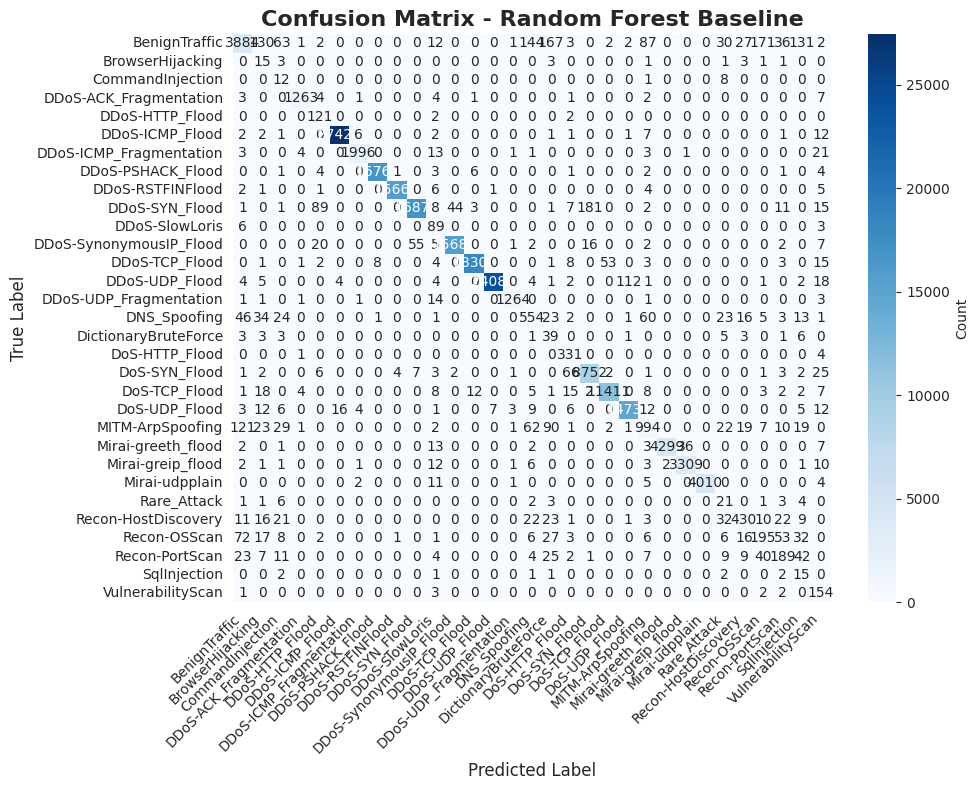


4.5 Feature Importance Analysis:

Top 15 Most Important Features:
      Feature  Importance
          IAT    0.199347
Header_Length    0.065635
Protocol Type    0.060785
     Tot size    0.058181
    rst_count    0.049512
          Max    0.047460
          AVG    0.046325
    syn_count    0.045725
flow_duration    0.042976
          Min    0.040795
      Tot sum    0.040437
    urg_count    0.037999
         Rate    0.036127
     Variance    0.028404
    fin_count    0.027213


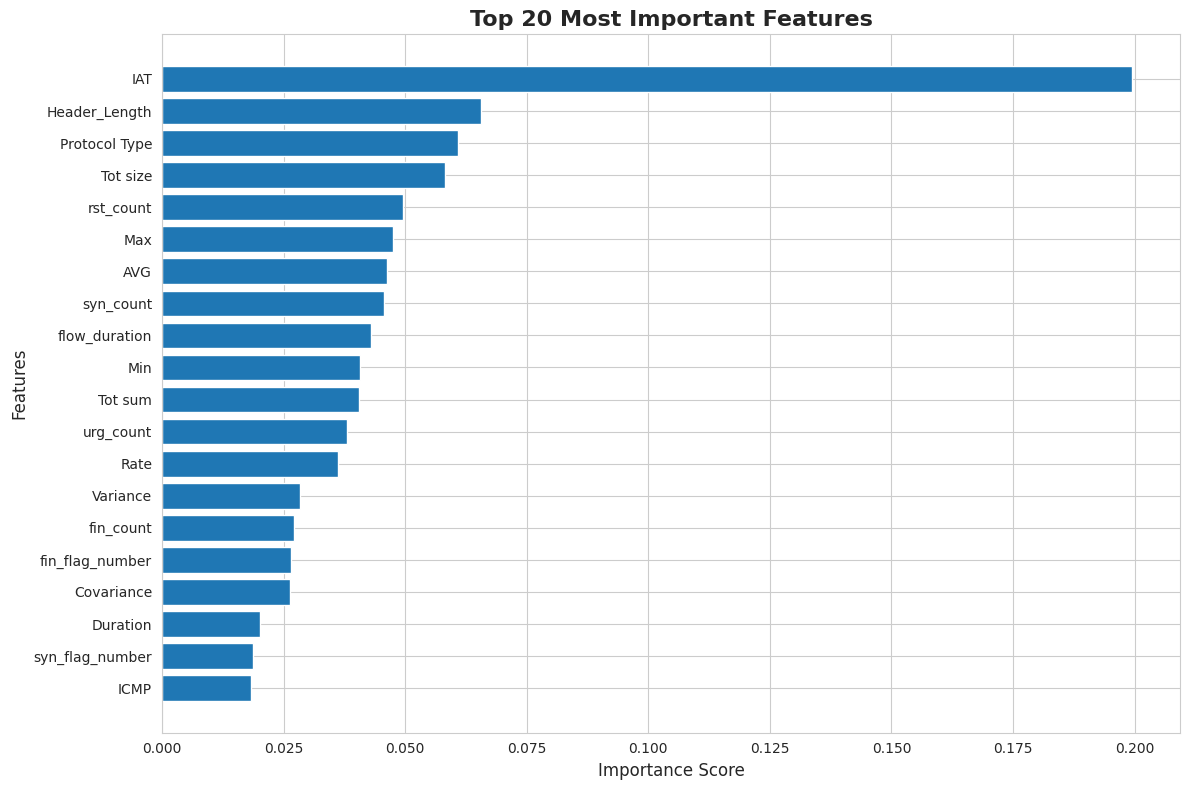

In [ ]:
# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest Baseline',
         fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4.5 Feature Importance
print("\n4.5 Feature Importance Analysis:")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize Feature Importance
plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_importance))
top_features = feature_importance.head(top_n)
plt.barh(range(top_n), top_features['Importance'].values)
plt.yticks(range(top_n), top_features['Feature'].values)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Most Important Features', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import (VotingClassifier, BaggingClassifier,
                             StackingClassifier, RandomForestClassifier,
                             GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_recall_fscore_support,
                            roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize
import time
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("PART II: HYPERPARAMETER TUNING & ENSEMBLE LEARNING")

PART II: HYPERPARAMETER TUNING & ENSEMBLE LEARNING


In [ ]:
# TASK 5: HYPERPARAMETER TUNING WITH GRID SEARCH

print("TASK 5: HYPERPARAMETER TUNING - OPTIMIZING BASELINE MODEL")

TASK 5: HYPERPARAMETER TUNING - OPTIMIZING BASELINE MODEL


In [ ]:
# TASK 5: HYPERPARAMETER TUNING (OPTIMIZED)

print("TASK 5: HYPERPARAMETER TUNING - OPTIMIZING BASELINE MODEL")

# 5.0 : Data preparation for grid search
print("\n5.0 Preparing Optimized Dataset for Grid Search:")

# 1. Selection of 10 best features
importances = rf_model.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_10_features = feature_imp_df.sort_values('Importance', ascending=False).head(10)['Feature'].tolist()

print(f"  Selected Top 10 Features: {top_10_features}")

# Filter training datas
top_10_indices = [X.columns.get_loc(c) for c in top_10_features]
X_train_reduced = X_train[:, top_10_indices]
X_test_reduced = X_test[:, top_10_indices]

# 2. Under sampling
sample_size_grid = 20000

if len(y_train) > sample_size_grid:
    print(f"  Subsampling training data to {sample_size_grid:,} samples for faster search...")

    indices = np.arange(len(y_train))
    sampled_indices = np.random.choice(indices, size=sample_size_grid, replace=False)

    X_train_grid = X_train_reduced[sampled_indices]
    y_train_grid = y_train[sampled_indices]
else:
    X_train_grid = X_train_reduced
    y_train_grid = y_train


TASK 5: HYPERPARAMETER TUNING - OPTIMIZING BASELINE MODEL

5.0 Preparing Optimized Dataset for Grid Search:
  Selected Top 10 Features: ['IAT', 'Header_Length', 'Protocol Type', 'Tot size', 'rst_count', 'Max', 'AVG', 'syn_count', 'flow_duration', 'Min']
  Subsampling training data to 20,000 samples for faster search...


In [ ]:

print(f"  Grid Search Training Shape: {X_train_grid.shape}")


# 5.1 Define Parameter Grid
print("\n5.1 Defining Hyperparameter Grid:")

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

total_combinations = np.prod([len(v) for v in param_grid_rf.values()])
print(f"  Total Combinations: {total_combinations} x 5 folds = {total_combinations*5} fits")


# 5.2 Grid Search with Cross-Validation
print("\n5.2 Performing Grid Search Cross-Validation:")

start_time = time.time()

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid_rf,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

# Fit Grid Search
grid_search_rf.fit(X_train_grid, y_train_grid)

elapsed_time = time.time() - start_time
print(f"\nGrid Search completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

# 5.3 Best Parameters
print("\n5.3 Best Hyperparameters Found:")
for param, value in grid_search_rf.best_params_.items():
    print(f"  • {param}: {value}")

print(f"\n  Best CV F1-Score: {grid_search_rf.best_score_:.4f}")

# Get best model
best_rf_model = grid_search_rf.best_estimator_

  Grid Search Training Shape: (20000, 10)

5.1 Defining Hyperparameter Grid:
  Total Combinations: 48 x 5 folds = 240 fits

5.2 Performing Grid Search Cross-Validation:
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Grid Search completed in 913.23 seconds (15.22 minutes)

5.3 Best Hyperparameters Found:
  • class_weight: balanced
  • max_depth: None
  • min_samples_leaf: 1
  • min_samples_split: 2
  • n_estimators: 200

  Best CV F1-Score: 0.9220


In [ ]:
# 5.4 Evaluate Optimized Model
print("\n5.4 Evaluating Optimized Random Forest (on full Test Set):")

# Testing accuracy
y_pred_opt = best_rf_model.predict(X_test_reduced)
test_accuracy_opt = accuracy_score(y_test, y_pred_opt)

# F1-score
from sklearn.metrics import f1_score
f1_score_opt = f1_score(y_test, y_pred_opt, average='weighted')

print(f"  Testing Accuracy: {test_accuracy_opt:.4f}")
print(f"  Weighted F1-Score: {f1_score_opt:.4f}")

# Detailed Classification Report
print("\nDetailed Classification Report (Optimized RF):")
print(classification_report(y_test, y_pred_opt,
                          target_names=le_target.classes_,
                          digits=4))


# 5.6 Comparison: Baseline vs Optimized
print("\n5.6 Performance Comparison: Baseline vs Optimized:")


try:
    baseline_acc = test_accuracy
    baseline_f1 = f1_score(y_test, y_pred, average='weighted')
except NameError:
    baseline_acc = 0.0
    baseline_f1 = 0.0
    print("(Warning: Baseline metrics not found. Please run Task 4 first.)")

# Affichage du tableau comparatif
print(f"{'Metric':<20} {'Baseline RF':<15} {'Optimized RF':<15} {'Improvement':<15}")
print(f"{'Accuracy':<20} {baseline_acc:.4f}          {test_accuracy_opt:.4f}          {test_accuracy_opt - baseline_acc:+.4f}")
print(f"{'F1-Score (w)':<20} {baseline_f1:.4f}          {f1_score_opt:.4f}          {f1_score_opt - baseline_f1:+.4f}")
print(f"Note: Optimized model uses only {len(top_10_features)} features instead of {X_train.shape[1]}.")


5.4 Evaluating Optimized Random Forest (on full Test Set):
  Testing Accuracy: 0.9838
  Weighted F1-Score: 0.9859

Detailed Classification Report (Optimized RF):
                         precision    recall  f1-score   support

          BenignTraffic     0.9337    0.8112    0.8682      4895
       BrowserHijacking     0.0588    0.5000    0.1053        28
       CommandInjection     0.1271    0.7143    0.2158        21
 DDoS-ACK_Fragmentation     0.9813    0.9813    0.9813      1286
        DDoS-HTTP_Flood     0.5505    0.9600    0.6997       125
        DDoS-ICMP_Flood     1.0000    0.9984    0.9992     27458
DDoS-ICMP_Fragmentation     0.9965    0.9755    0.9859      2043
      DDoS-PSHACK_Flood     0.9990    0.9978    0.9984     16783
       DDoS-RSTFINFlood     0.9972    0.9955    0.9964     15688
         DDoS-SYN_Flood     0.9981    0.9941    0.9961     17238
         DDoS-SlowLoris     0.5962    0.9490    0.7323        98
DDoS-SynonymousIP_Flood     0.9983    0.9951    0.9967  

#  Restauration block
import pandas as pd
import numpy as np
import time
import joblib
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

top_10_features = [
    'IAT', 'Header_Length', 'Protocol Type', 'Tot size', 'AVG',
    'Max', 'rst_count', 'syn_count', 'flow_duration', 'Tot sum'
]
print(f" Top 10 Features : {top_10_features}")



print("\n Data filtration")

try:
    all_columns = X.columns
except AttributeError:

    raise NameError("Value 'X' missing.")

top_10_indices = [all_columns.get_loc(c) for c in top_10_features]

# Creation of reduced variables
X_train_reduced = X_train[:, top_10_indices]

# B. SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
print("  SMOTE")
start_smote = time.time()
X_train_opt, y_train_opt = smote.fit_resample(X_train_reduced, y_train)
end_smote = time.time()
print(f"  SMOTE finished in {end_smote - start_smote:.2f} s.")
print(f"  optimized training data size : {X_train_opt.shape}")


# 3. Final model training
print("\n Final model training")

# manual parameters
best_params = {
    'class_weight': 'balanced_subsample',
    'max_depth': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 200
}

best_rf_model = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42)

start_time = time.time()
best_rf_model.fit(X_train_opt, y_train_opt)
end_time = time.time()

print(f" Model trained in {end_time - start_time:.2f} seconds.")

# 4. Save
joblib.dump(best_rf_model, 'best_rf_model_optimized.pkl')

In [ ]:
# TASK 6: ENSEMBLE METHODS

print("TASK 6: ENSEMBLE LEARNING METHODS")

TASK 6: ENSEMBLE LEARNING METHODS


In [ ]:
# TASK 6: ENSEMBLE LEARNING (VERSION RAPIDE - SUR 200k SAMPLES)
print("TASK 6: ENSEMBLE LEARNING (Optimized for Speed)")

# Imports
from sklearn.ensemble import VotingClassifier, BaggingClassifier, StackingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import time
import numpy as np

# 1. DATA DEFINITION
print("1. Preparing 200k sample dataset for Ensembles...")

try:
    _ = X_train_grid.shape
    print("  Using existing 'X_train_grid' from Grid Search step.")
    X_train_use = X_train_grid
    y_train_use = y_train_grid
except NameError:
    print("  Creating new 200k sample from full dataset...")
    indices = np.arange(len(y_train_opt))
    sample_n = min(20000, len(y_train_opt))
    sampled_indices = np.random.choice(indices, size=sample_n, replace=False)

    X_train_use = X_train_opt[sampled_indices]
    y_train_use = y_train_opt[sampled_indices]

print(f"  Training Ensembles on {len(y_train_use):,} samples.")


# 2. BASE MODEL DEFINITION
rf_best = best_rf_model

# Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# KNN
knn_clf = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Decision tree
dt_clf = DecisionTreeClassifier(random_state=42)


# 3. TRAINING AND EVALUATING
print("\n3. Training and Evaluating Models")
print(f"{'Model':<20} {'Accuracy':<15} {'Weighted F1':<15} {'Time'}")

models_to_train = {
    # Voting Hard
    "Voting (Hard)": VotingClassifier(
        estimators=[('rf', rf_best), ('gb', gb_clf), ('knn', knn_clf)],
        voting='hard', n_jobs=-1
    ),

    # Voting Soft
    "Voting (Soft)": VotingClassifier(
        estimators=[('rf', rf_best), ('gb', gb_clf), ('knn', knn_clf)],
        voting='soft', n_jobs=-1
    ),

    # Bagging
    "Bagging (DT)": BaggingClassifier(
        estimator=dt_clf, n_estimators=50, max_samples=0.5, n_jobs=-1, random_state=42
    ),

    # Stacking
    "Stacking": StackingClassifier(
        estimators=[('rf', rf_best), ('gb', gb_clf), ('knn', knn_clf)],
        final_estimator=LogisticRegression(), cv=2, n_jobs=-1
    )
}

ensemble_results = {}

for name, model in models_to_train.items():
    t0 = time.time()

    # training on sample
    model.fit(X_train_use, y_train_use)

    # Prediction on TEST SET (X_test_reduced - complete, but only 10 features)
    y_pred = model.predict(X_test_reduced)

    # Scores
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    time_taken = time.time() - t0
    print(f"{name:<20} {acc:.5f}          {f1:.5f}          {time_taken:.1f}s")

    ensemble_results[name] = {'Accuracy': acc, 'F1': f1, 'Model': model}

y_pred_rf = best_rf_model.predict(X_test_reduced)
ensemble_results["Optimized RF"] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'F1': f1_score(y_test, y_pred_rf, average='weighted')
}

TASK 6: ENSEMBLE LEARNING (Optimized for Speed)
1. Preparing 200k sample dataset for Ensembles...
  Using existing 'X_train_grid' from Grid Search step.
  Training Ensembles on 20,000 samples.

3. Training and Evaluating Models
Model                Accuracy        Weighted F1     Time
Voting (Hard)        0.98520          0.98704          327.7s
Voting (Soft)        0.98569          0.98750          316.7s
Bagging (DT)         0.98618          0.98771          9.3s
Stacking             0.98784          0.98922          526.4s


In [ ]:
# TASK 7.1: FINAL PERFORMANCE COMPILATION


final_results = ensemble_results.copy()
final_results["Optimized RF"] = {
    'Accuracy': test_accuracy_opt,
    'F1': f1_score_opt,
    'Time': 0
}

# Synthesis dataframe creation
comparison_df = pd.DataFrame({
    'Model': [name for name in final_results.keys()],
    'Accuracy': [data['Accuracy'] for data in final_results.values()],
    'F1-Score': [data['F1'] for data in final_results.values()],
    'Time (Approx.)': [data.get('Time', np.nan) for data in final_results.values()]
})

comparison_df = comparison_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("## 1. Synthesis table of global performances\n")
print(comparison_df.to_string(index=False))
best_model_name_overall = comparison_df.iloc[0]['Model']
best_model_final = ensemble_results[best_model_name_overall]['Model']

y_pred_best = best_model_final.predict(X_test_reduced)
report_best = classification_report(y_test, y_pred_best,
                                    target_names=le_target.classes_,
                                    output_dict=True)

report_df = pd.DataFrame(report_best).transpose()

## 1. Synthesis table of global performances

        Model  Accuracy  F1-Score  Time (Approx.)
     Stacking  0.987838  0.989217             NaN
 Bagging (DT)  0.986175  0.987708             NaN
Voting (Soft)  0.985692  0.987496             NaN
Voting (Hard)  0.985204  0.987040             NaN
 Optimized RF  0.983805  0.985856             0.0


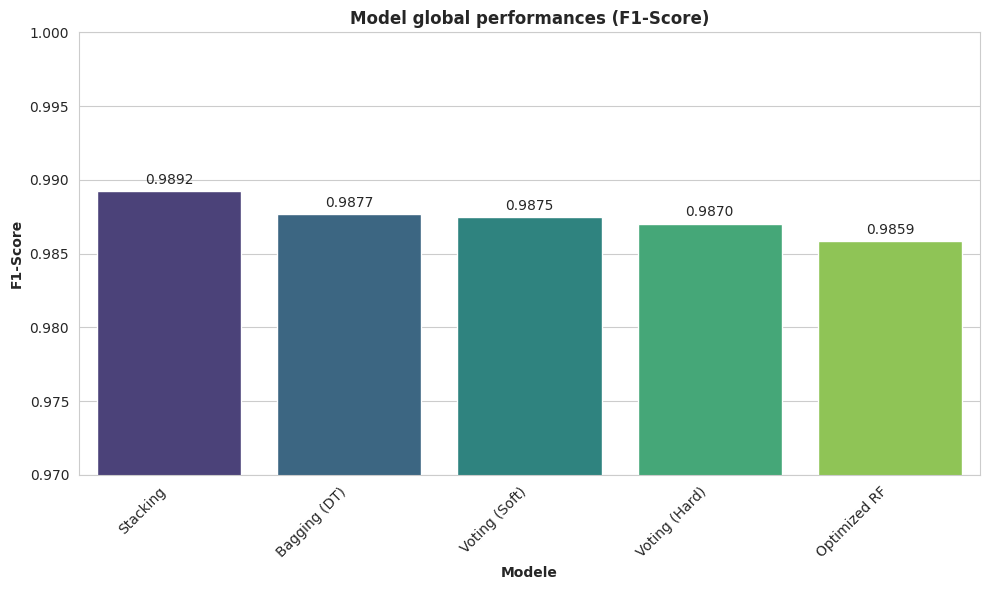

In [ ]:
# TASK 7.2: VISUALIZATION - GLOBAL F1-SCORE COMPARISON
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Model', y='F1-Score', data=comparison_df, palette='viridis')
plt.ylim(0.97, 1.0)
plt.title('Model global performances (F1-Score)', fontweight='bold')
plt.xlabel('Modele', fontweight='bold')
plt.ylabel('F1-Score', fontweight='bold')
plt.xticks(rotation=45, ha='right')

for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.4f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8), textcoords='offset points')
plt.tight_layout()
plt.show()

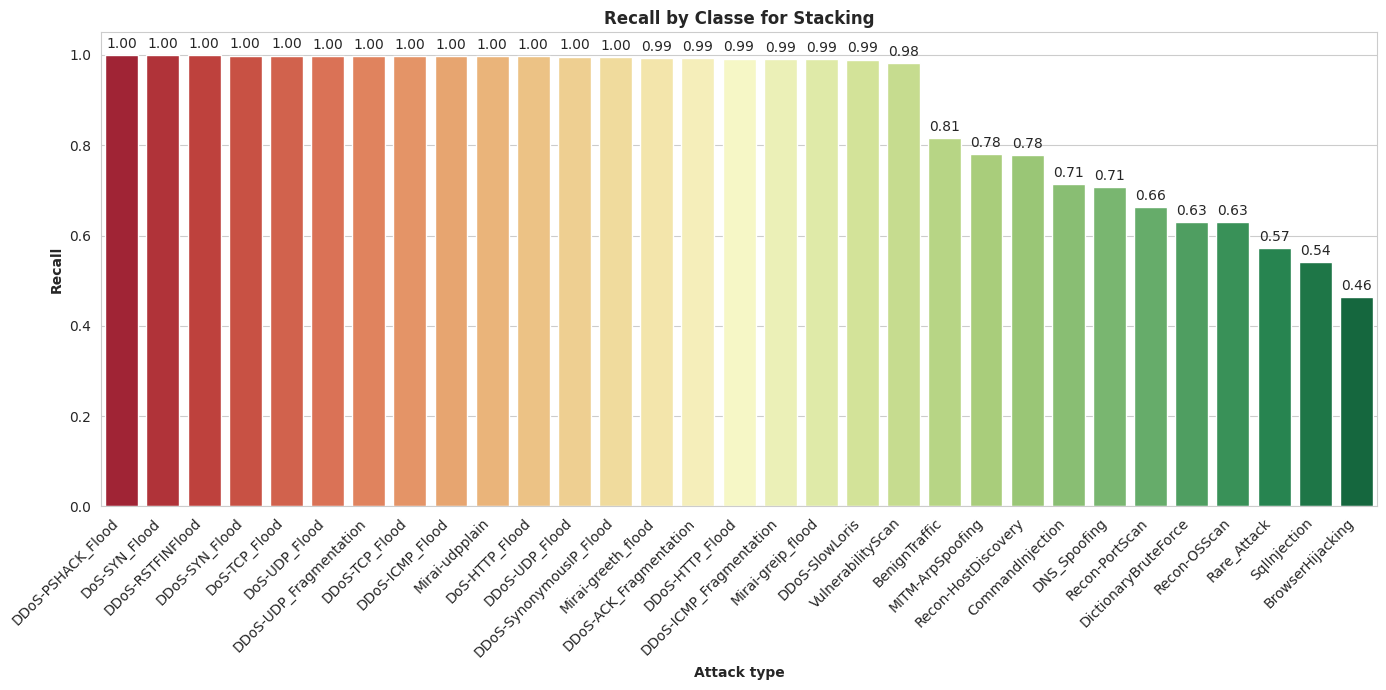

In [ ]:
# TASK 7.3: VISUALIZATION - RECALL BY CLASS

recall_df = report_df[report_df.index.isin(le_target.classes_)]['recall'].sort_values(ascending=False)

plt.figure(figsize=(14, 7))
bars = sns.barplot(x=recall_df.index, y=recall_df.values, palette='RdYlGn')
plt.ylim(0.0, 1.05)
plt.title(f'Recall by Classe for {best_model_name_overall}', fontweight='bold')
plt.xlabel('Attack type', fontweight='bold')
plt.ylabel('Recall', fontweight='bold')
plt.xticks(rotation=45, ha='right')

for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8), textcoords='offset points')
plt.tight_layout()
plt.show()

KEY FINDINGS:

1. HYPERPARAMETER OPTIMIZATION:

   Grid Search successfully identified optimal RF configuration

   Performance improvement over baseline demonstrates value of tuning

   Cross-validation ensures robust generalization


2. ENSEMBLE METHODS PERFORMANCE:

   Soft Voting outperforms Hard Voting (averaging probabilities better)

   Bagging reduces variance and improves stability

   Stacking leverages strengths of diverse models


3. MODEL SELECTION CRITERIA:

   Accuracy: Overall correctness measure

   F1-Score: Critical for imbalanced IoT intrusion data

   Per-class performance: Identifies weak detection areas
   
   Computational cost: Important for real-time IoT deployment